# COVID-19 Literature Clustering

# Table of Contents
1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Dimensionality Reduction with t-SNE
6. Topic Modeling on Each Cluster
7. Classify
8. Plot
9. How to Use the Plot?
10. Conclusion
11. Citation/Sources

<br>

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
from Bio import Entrez
from Bio import Medline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [20]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

#### specification du nombre de fichiers a lire : 

In [57]:
max_articles = 5000

In [58]:
Entrez.email = 'A.N.Other@example.com'
h = Entrez.esearch(db='pubmed', retmax=max_articles, term="coronavirus")
result = Entrez.read(h)
result
ids = result['IdList']
h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
records = Medline.parse(h)

In [59]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(records):

    if idx >max_articles:
        break
    try:
        dict_['paper_id'].append(entry["PMID"])
    except Exception as e:
        dict_['paper_id'].append("")
        
    try:
        dict_['abstract'].append(entry["AB"])
        # also create a column for the summary of abstract to be used in a plot
        if len(entry["AB"]) == 0: 
            # no abstract provided
            dict_['abstract_summary'].append("Not provided.")
        elif len(entry["AB"].split(' ')) > 100:
            # abstract provided is too long for plot, take first 100 words append with ...
            info = entry["AB"].split(' ')[:100]
            summary = get_breaks(' '.join(info), 40)
            dict_['abstract_summary'].append(summary + "...")
        else:
            # abstract is short enough
            summary = get_breaks(entry["AB"], 40)
            dict_['abstract_summary'].append(summary)
    except Exception as e:
        dict_['abstract'].append("")  
        dict_['abstract_summary'].append("Not provided.")

        
    try:
        dict_['body_text'].append(entry["AB"])
    except Exception as e:
        dict_['body_text'].append("")     
    
   
    
    
    try:
        # if more than one author
        authors = entry['AU'][0].split(',')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        try : 
            dict_['authors'].append(entry['AU'][0])
        except Exception as e:
            dict_['authors'].append("")


    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(entry['TI'][0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        try:
            dict_['title'].append(entry['TI'][0])
        except Exception as e:
            dict_['title'].append("")
    
    # add the journal information
    dict_['journal'].append(entry['PT'][0])
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          5000 non-null   object
 1   abstract          5000 non-null   object
 2   body_text         5000 non-null   object
 3   authors           5000 non-null   object
 4   title             5000 non-null   object
 5   journal           5000 non-null   object
 6   abstract_summary  5000 non-null   object
dtypes: object(7)
memory usage: 273.6+ KB


## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [60]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,33930904,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,Manchanda RK,H,Journal Article,BACKGROUND/OBJECTIVE: Coronavirus disease<br>...,249,249,171
1,33930819,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,Kurt-Jones EA,E,Journal Article,SARS coronavirus 1 (SARS-CoV-1) causes a<br>r...,149,149,91
2,33930765,The coronavirus disease 2019 (COVID-19) pandem...,The coronavirus disease 2019 (COVID-19) pandem...,Kitano T,T,Journal Article,The coronavirus disease 2019 (COVID-19)<br>pa...,208,208,110
3,33930707,The calamity of the novel severe acute respira...,The calamity of the novel severe acute respira...,Bayat M,E,Journal Article,The calamity of the novel severe acute<br>res...,149,149,108
4,33930705,The ongoing severe acute respiratory syndrome ...,The ongoing severe acute respiratory syndrome ...,Shah Alam M,T,Journal Article,The ongoing severe acute respiratory syndrome...,151,151,94


In [61]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             5000 non-null   object
 1   abstract             5000 non-null   object
 2   body_text            5000 non-null   object
 3   authors              5000 non-null   object
 4   title                5000 non-null   object
 5   journal              5000 non-null   object
 6   abstract_summary     5000 non-null   object
 7   abstract_word_count  5000 non-null   int64 
 8   body_word_count      5000 non-null   int64 
 9   body_unique_words    5000 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 390.8+ KB


In [62]:
df_covid['abstract'].describe(include='all')

count     5000
unique    4543
top           
freq       454
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [63]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count                                                  4543
unique                                                 4543
top       In March 2020, New York City (NYC) experienced...
freq                                                      1
Name: abstract, dtype: object

In [64]:
df_covid['body_text'].describe(include='all')

count                                                  4543
unique                                                 4543
top       In March 2020, New York City (NYC) experienced...
freq                                                      1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [65]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,33930904,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,Manchanda RK,H,Journal Article,BACKGROUND/OBJECTIVE: Coronavirus disease<br>...,249,249,171
1,33930819,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,Kurt-Jones EA,E,Journal Article,SARS coronavirus 1 (SARS-CoV-1) causes a<br>r...,149,149,91
2,33930765,The coronavirus disease 2019 (COVID-19) pandem...,The coronavirus disease 2019 (COVID-19) pandem...,Kitano T,T,Journal Article,The coronavirus disease 2019 (COVID-19)<br>pa...,208,208,110
3,33930707,The calamity of the novel severe acute respira...,The calamity of the novel severe acute respira...,Bayat M,E,Journal Article,The calamity of the novel severe acute<br>res...,149,149,108
4,33930705,The ongoing severe acute respiratory syndrome ...,The ongoing severe acute respiratory syndrome ...,Shah Alam M,T,Journal Article,The ongoing severe acute respiratory syndrome...,151,151,94


In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [66]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,4543.000000,4543.000000,4543.000000
mean,218.115122,218.115122,140.428792
std,85.064944,85.064944,44.022848
min,0.000000,0.000000,0.000000
25%,165.000000,165.000000,114.000000
50%,215.000000,215.000000,141.000000
75%,259.000000,259.000000,165.000000
max,1845.000000,1845.000000,770.000000


# Data Pre-processing

### Réduction de la taille du dataset :

In [67]:

#df = df_covid.sample(4000, random_state=42)
df = df_covid

### Suppression des valeurs null :

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [68]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4543 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             4543 non-null   object
 1   abstract             4543 non-null   object
 2   body_text            4543 non-null   object
 3   authors              4543 non-null   object
 4   title                4543 non-null   object
 5   journal              4543 non-null   object
 6   abstract_summary     4543 non-null   object
 7   abstract_word_count  4543 non-null   int64 
 8   body_word_count      4543 non-null   int64 
 9   body_unique_words    4543 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 390.4+ KB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [69]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 4543/4543 [00:25<00:00, 180.54it/s]


In [70]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 4543

{'ca': 1, 'en': 4532, 'es': 2, 'hu': 6, 'it': 1, 'ro': 1}


Lets take a look at the language distribution in the dataset

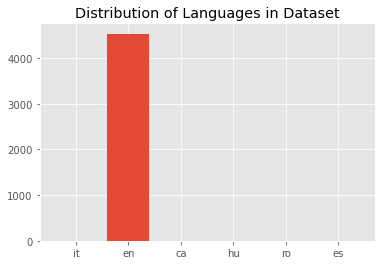

In [71]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [72]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4532 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             4532 non-null   object
 1   abstract             4532 non-null   object
 2   body_text            4532 non-null   object
 3   authors              4532 non-null   object
 4   title                4532 non-null   object
 5   journal              4532 non-null   object
 6   abstract_summary     4532 non-null   object
 7   abstract_word_count  4532 non-null   int64 
 8   body_word_count      4532 non-null   int64 
 9   body_unique_words    4532 non-null   int64 
 10  language             4532 non-null   object
dtypes: int64(3), object(8)
memory usage: 424.9+ KB


In [73]:
#Download the spacy bio parser

from IPython.utils import io
# with io.capture_output() as captured:
#    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [74]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [75]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [76]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords

['elsewhere',
 'and',
 'n’t',
 'whose',
 'into',
 'him',
 'about',
 'further',
 'almost',
 'mine',
 'n‘t',
 'hereupon',
 'serious',
 'ever',
 'rather',
 'upon',
 'thru',
 'however',
 'whither',
 'own',
 'again',
 'since',
 'hence',
 'alone',
 'neither',
 '’d',
 'now',
 'such',
 'thence',
 'latterly',
 'six',
 'four',
 'whereafter',
 'perhaps',
 'one',
 'its',
 'out',
 'under',
 'some',
 'that',
 "'ll",
 'or',
 'cannot',
 'how',
 'whom',
 'of',
 "'d",
 'enough',
 'both',
 'been',
 'together',
 'becomes',
 'between',
 'herself',
 'may',
 'not',
 'was',
 'them',
 'before',
 'sometime',
 'becoming',
 'us',
 'an',
 'fifteen',
 'per',
 'already',
 'at',
 'this',
 'against',
 '‘d',
 'keep',
 'top',
 'itself',
 'using',
 'within',
 'via',
 'above',
 'me',
 'go',
 'regarding',
 'themselves',
 'beforehand',
 'none',
 'either',
 'toward',
 'nowhere',
 'just',
 'what',
 'do',
 'wherein',
 'namely',
 'everywhere',
 'front',
 'when',
 'can',
 'thereafter',
 'their',
 'she',
 'for',
 'somehow',
 'mus

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [77]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [78]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    #mytokens = [ word.lemma.lower().strip() if word.pos_ != "-PRON-" else word.lower for word.text in mytokens ]
    #mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text not in stopwords]

    mytokens = [ word for word in mytokens if word not in stopwords and word.text not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [79]:
cat = 5
type(cat)

int

Applying the text-processing function on the **body_text**. 

In [80]:
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#c'est dans cette partie la que ça bug , ça prend un temps énorme et on a pas eu de résultat  
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#tqdm.pandas()
#df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

In [81]:
import spacy
nlp = en_core_web_lg.load()
def spacy_process(texte):
    tmp = []
    tmp.append(texte)
    for lt in tmp:
        mytokens = nlp(lt)
        mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text not in stopwords]
        mytokens2 = " ".join([i for i in mytokens2])
    return mytokens2
df["processed_text"] = df["body_text"].apply(spacy_process)

<ipython-input-81-f3ac0eca20f0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_text"] = df["body_text"].apply(spacy_process)


In [82]:
df.head()


,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text
0,33930904,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,Manchanda RK,H,Journal Article,BACKGROUND/OBJECTIVE: Coronavirus disease<br>...,249,249,171,en,background / objective coronavirus disease 201...
1,33930819,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,Kurt-Jones EA,E,Journal Article,SARS coronavirus 1 (SARS-CoV-1) causes a<br>r...,149,149,91,en,sars coronavirus 1 sars cov-1 cause respirator...
2,33930765,The coronavirus disease 2019 (COVID-19) pandem...,The coronavirus disease 2019 (COVID-19) pandem...,Kitano T,T,Journal Article,The coronavirus disease 2019 (COVID-19)<br>pa...,208,208,110,en,the coronavirus disease 2019 covid-19 pandemic...
3,33930707,The calamity of the novel severe acute respira...,The calamity of the novel severe acute respira...,Bayat M,E,Journal Article,The calamity of the novel severe acute<br>res...,149,149,108,en,the calamity novel severe acute respiratory sy...
4,33930705,The ongoing severe acute respiratory syndrome ...,The ongoing severe acute respiratory syndrome ...,Shah Alam M,T,Journal Article,The ongoing severe acute respiratory syndrome...,151,151,94,en,the ongoing severe acute respiratory syndrome ...


### Removal of Frequent words
So this step is to remove the frequent words in the given corpus. If we use something like tfidf, this is automatically taken care of.

In [83]:
from collections import Counter
cnt = Counter()
for text in df["processed_text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(40)

[('covid-19', 13165),
 ('%', 8908),
 ('patient', 8602),
 ('the', 7860),
 ('sars', 5764),
 ('-', 5435),
 ('cov-2', 5308),
 ('disease', 4997),
 ('study', 4879),
 ('coronavirus', 4681),
 ('pandemic', 4593),
 ('health', 3432),
 ('infection', 3305),
 ('result', 3274),
 ('high', 2823),
 ('severe', 2670),
 ('2019', 2563),
 ('we', 2544),
 ('case', 2440),
 ('in', 2363),
 ('respiratory', 2337),
 ('=', 2276),
 ('include', 2262),
 ('risk', 2177),
 ('2020', 2139),
 ('method', 2072),
 ('this', 2061),
 ('clinical', 2057),
 ('2', 2050),
 ('p', 1986),
 ('acute', 1951),
 ('increase', 1911),
 ('care', 1907),
 ('report', 1899),
 ('datum', 1872),
 ('/', 1864),
 ('virus', 1777),
 ('test', 1755),
 ('analysis', 1718),
 ('associate', 1700)]

In [84]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(30)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["processed_text"].apply(lambda text: remove_freqwords(text))


<ipython-input-84-e97c1f8b22c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_wo_stopfreq"] = df["processed_text"].apply(lambda text: remove_freqwords(text))


In [85]:
df["body_text"]

0       BACKGROUND/OBJECTIVE: Coronavirus disease 2019...
1       SARS coronavirus 1 (SARS-CoV-1) causes a respi...
2       The coronavirus disease 2019 (COVID-19) pandem...
3       The calamity of the novel severe acute respira...
4       The ongoing severe acute respiratory syndrome ...
                              ...                        
4995    Aim: This study aimed to investigate the impac...
4996    Aim: COVID-19, the disease caused by the novel...
4997    Introduction Coronavirus disease 2019 (COVID-1...
4998    Severe acute respiratory syndrome coronavirus ...
4999    As the world has struggled to adapt to the cor...
Name: body_text, Length: 4532, dtype: object

In [86]:
df["text_wo_stopfreq"]

0       background / objective new profile natural his...
1       1 cov-1 cause lead acute distress characterize...
2       disrupt childhood vaccination pneumococcal con...
3       calamity novel acute syndrome cov2 global huma...
4       ongoing acute syndrome have disastrous impact ...
                              ...                        
4995    aim aim investigate impact acute syndrome type...
4996    aim cause novel worldwide reason disturbance c...
4997    introduction emerge global place unprecedented...
4998    acute syndrome typically present symptom prese...
4999    as world struggle adapt new evidence emerge su...
Name: text_wo_stopfreq, Length: 4532, dtype: object

In [87]:
df["processed_text"]

0       background / objective coronavirus disease 201...
1       sars coronavirus 1 sars cov-1 cause respirator...
2       the coronavirus disease 2019 covid-19 pandemic...
3       the calamity novel severe acute respiratory sy...
4       the ongoing severe acute respiratory syndrome ...
                              ...                        
4995    aim this study aim investigate impact severe a...
4996    aim covid-19 disease cause novel coronavirus w...
4997    introduction coronavirus disease 2019 covid-19...
4998    severe acute respiratory syndrome coronavirus ...
4999    as world struggle adapt coronavirus disease co...
Name: processed_text, Length: 4532, dtype: object

### Removal of Rare words
This is very similar to previous preprocessing step but we will remove the rare words from the corpus.

In [88]:
#cnt.most_common()[:-500-1:-1]

In [89]:
# n_rare_words = 10
# RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
# def remove_rarewords(text):
#     """custom function to remove the rare words"""
#     return " ".join([word for word in str(text).split() if word not in RAREWORDS])

# df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
# df.head()

### Lemmatization

Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

In [90]:
import nltk
#nltk.download('wordnet')

In [91]:
#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()
#def lemmatize_words(text):
#    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])#
#df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))
#df.head()

Now let us redo the lemmatization process for our dataset.

In [92]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Seyf_GOUMEIDA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [93]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))


<ipython-input-93-a975cedaa34d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))


In [94]:
df.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized
0,33930904,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,Manchanda RK,H,Journal Article,BACKGROUND/OBJECTIVE: Coronavirus disease<br>...,249,249,171,en,background / objective coronavirus disease 201...,background / objective new profile natural his...,background / objective new profile natural his...
1,33930819,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,Kurt-Jones EA,E,Journal Article,SARS coronavirus 1 (SARS-CoV-1) causes a<br>r...,149,149,91,en,sars coronavirus 1 sars cov-1 cause respirator...,1 cov-1 cause lead acute distress characterize...,1 cov-1 cause lead acute distress characterize...
2,33930765,The coronavirus disease 2019 (COVID-19) pandem...,The coronavirus disease 2019 (COVID-19) pandem...,Kitano T,T,Journal Article,The coronavirus disease 2019 (COVID-19)<br>pa...,208,208,110,en,the coronavirus disease 2019 covid-19 pandemic...,disrupt childhood vaccination pneumococcal con...,disrupt childhood vaccination pneumococcal con...
3,33930707,The calamity of the novel severe acute respira...,The calamity of the novel severe acute respira...,Bayat M,E,Journal Article,The calamity of the novel severe acute<br>res...,149,149,108,en,the calamity novel severe acute respiratory sy...,calamity novel acute syndrome cov2 global huma...,calamity novel acute syndrome cov2 global huma...
4,33930705,The ongoing severe acute respiratory syndrome ...,The ongoing severe acute respiratory syndrome ...,Shah Alam M,T,Journal Article,The ongoing severe acute respiratory syndrome...,151,151,94,en,the ongoing severe acute respiratory syndrome ...,ongoing acute syndrome have disastrous impact ...,ongoing acute syndrome have disastrous impact ...


### Removal of URLs

In [95]:
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [96]:
df["text_lemmatized_no_url"] = df["text_lemmatized"].apply(lambda text: remove_urls(text))
df.head()
    

<ipython-input-96-a38abe2b0ba1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized_no_url"] = df["text_lemmatized"].apply(lambda text: remove_urls(text))


,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url
0,33930904,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,Manchanda RK,H,Journal Article,BACKGROUND/OBJECTIVE: Coronavirus disease<br>...,249,249,171,en,background / objective coronavirus disease 201...,background / objective new profile natural his...,background / objective new profile natural his...,background / objective new profile natural his...
1,33930819,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,Kurt-Jones EA,E,Journal Article,SARS coronavirus 1 (SARS-CoV-1) causes a<br>r...,149,149,91,en,sars coronavirus 1 sars cov-1 cause respirator...,1 cov-1 cause lead acute distress characterize...,1 cov-1 cause lead acute distress characterize...,1 cov-1 cause lead acute distress characterize...
2,33930765,The coronavirus disease 2019 (COVID-19) pandem...,The coronavirus disease 2019 (COVID-19) pandem...,Kitano T,T,Journal Article,The coronavirus disease 2019 (COVID-19)<br>pa...,208,208,110,en,the coronavirus disease 2019 covid-19 pandemic...,disrupt childhood vaccination pneumococcal con...,disrupt childhood vaccination pneumococcal con...,disrupt childhood vaccination pneumococcal con...
3,33930707,The calamity of the novel severe acute respira...,The calamity of the novel severe acute respira...,Bayat M,E,Journal Article,The calamity of the novel severe acute<br>res...,149,149,108,en,the calamity novel severe acute respiratory sy...,calamity novel acute syndrome cov2 global huma...,calamity novel acute syndrome cov2 global huma...,calamity novel acute syndrome cov2 global huma...
4,33930705,The ongoing severe acute respiratory syndrome ...,The ongoing severe acute respiratory syndrome ...,Shah Alam M,T,Journal Article,The ongoing severe acute respiratory syndrome...,151,151,94,en,the ongoing severe acute respiratory syndrome ...,ongoing acute syndrome have disastrous impact ...,ongoing acute syndrome have disastrous impact ...,ongoing acute syndrome have disastrous impact ...


### Removal of HTML Tags

In [97]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [98]:
df["text_lemmatized_url_html"] = df["text_lemmatized_no_url"].apply(lambda text: remove_html(text))
df.head()

<ipython-input-98-e19f1b691939>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized_url_html"] = df["text_lemmatized_no_url"].apply(lambda text: remove_html(text))


,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url,text_lemmatized_url_html
0,33930904,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,BACKGROUND/OBJECTIVE: Coronavirus disease 2019...,Manchanda RK,H,Journal Article,BACKGROUND/OBJECTIVE: Coronavirus disease<br>...,249,249,171,en,background / objective coronavirus disease 201...,background / objective new profile natural his...,background / objective new profile natural his...,background / objective new profile natural his...,background / objective new profile natural his...
1,33930819,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,SARS coronavirus 1 (SARS-CoV-1) causes a respi...,Kurt-Jones EA,E,Journal Article,SARS coronavirus 1 (SARS-CoV-1) causes a<br>r...,149,149,91,en,sars coronavirus 1 sars cov-1 cause respirator...,1 cov-1 cause lead acute distress characterize...,1 cov-1 cause lead acute distress characterize...,1 cov-1 cause lead acute distress characterize...,1 cov-1 cause lead acute distress characterize...
2,33930765,The coronavirus disease 2019 (COVID-19) pandem...,The coronavirus disease 2019 (COVID-19) pandem...,Kitano T,T,Journal Article,The coronavirus disease 2019 (COVID-19)<br>pa...,208,208,110,en,the coronavirus disease 2019 covid-19 pandemic...,disrupt childhood vaccination pneumococcal con...,disrupt childhood vaccination pneumococcal con...,disrupt childhood vaccination pneumococcal con...,disrupt childhood vaccination pneumococcal con...
3,33930707,The calamity of the novel severe acute respira...,The calamity of the novel severe acute respira...,Bayat M,E,Journal Article,The calamity of the novel severe acute<br>res...,149,149,108,en,the calamity novel severe acute respiratory sy...,calamity novel acute syndrome cov2 global huma...,calamity novel acute syndrome cov2 global huma...,calamity novel acute syndrome cov2 global huma...,calamity novel acute syndrome cov2 global huma...
4,33930705,The ongoing severe acute respiratory syndrome ...,The ongoing severe acute respiratory syndrome ...,Shah Alam M,T,Journal Article,The ongoing severe acute respiratory syndrome...,151,151,94,en,the ongoing severe acute respiratory syndrome ...,ongoing acute syndrome have disastrous impact ...,ongoing acute syndrome have disastrous impact ...,ongoing acute syndrome have disastrous impact ...,ongoing acute syndrome have disastrous impact ...


### Let's take a look at word count in the papers

In [99]:
import seaborn as sns

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    4532.000000
mean      218.075684
std        84.806138
min         0.000000
25%       165.000000
50%       215.000000
75%       259.000000
max      1845.000000
Name: body_word_count, dtype: float64

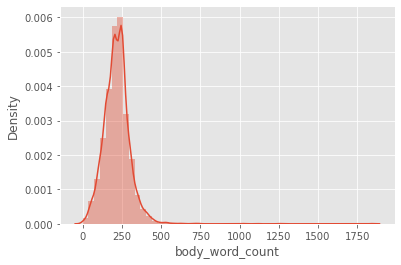

In [100]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    4532.000000
mean      140.376876
std        43.757342
min         0.000000
25%       114.000000
50%       141.000000
75%       165.000000
max       770.000000
Name: body_unique_words, dtype: float64

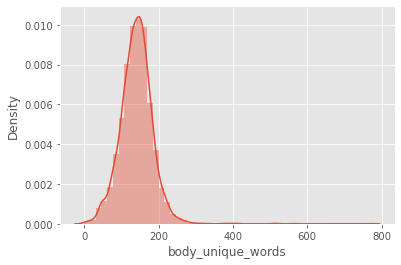

In [101]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    global vectorizer 
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [103]:
text = df['text_lemmatized_url_html'].values
vectorizer = TfidfVectorizer(max_features= 2 ** 12)
X = vectorize(text, 2 ** 12)
X.shape
print(X)

  (0, 917)	0.038636779076315526
  (0, 222)	0.07023791831294354
  (0, 914)	0.05446272324388135
  (0, 1558)	0.032319590448916906
  (0, 1934)	0.04816015161765147
  (0, 690)	0.047011994613024286
  (0, 1912)	0.06200987542087109
  (0, 442)	0.034378511785132654
  (0, 2312)	0.06096304542053501
  (0, 842)	0.02866321547092423
  (0, 1673)	0.056337811556412654
  (0, 1138)	0.09279347844365009
  (0, 1333)	0.06681027808153622
  (0, 677)	0.07056466870895414
  (0, 2599)	0.05290149691750643
  (0, 3422)	0.06200987542087109
  (0, 3867)	0.07568139341627246
  (0, 3705)	0.08375415977011684
  (0, 334)	0.07432674828232413
  (0, 381)	0.05615675157608247
  (0, 389)	0.09741871230777245
  (0, 1045)	0.047202350354527925
  (0, 1748)	0.07771528803172405
  (0, 1924)	0.03284478975794179
  (0, 2434)	0.08930954896541853
  :	:
  (4531, 1288)	0.08340926489195002
  (4531, 2258)	0.06941819826040913
  (4531, 3844)	0.14721315567021737
  (4531, 3845)	0.10809860027886371
  (4531, 2925)	0.05178204599575293
  (4531, 3186)	0.056158

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

In [104]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(4532, 2209)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [105]:
from sklearn.cluster import KMeans

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [106]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 10)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

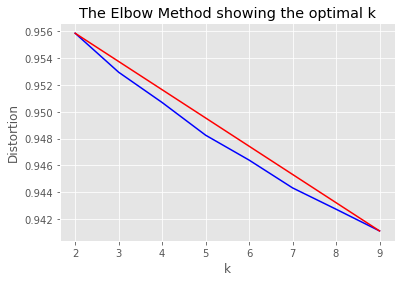

In [107]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In this plot we can see that the better k values are between 18-25. After that, the decrease in distortion is not as significant. For simplicity, we will use k=20

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [108]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred
df['y']

<ipython-input-108-fe9c866d954f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = y_pred


0       2
1       0
2       4
3       4
4       0
       ..
4995    1
4996    2
4997    1
4998    2
4999    2
Name: y, Length: 4532, dtype: int32

# Dimensionality Reduction with t-SNE

In [109]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 4532 samples in 7.423s...
[t-SNE] Computed neighbors for 4532 samples in 140.224s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4532
[t-SNE] Computed conditional probabilities for sample 2000 / 4532
[t-SNE] Computed conditional probabilities for sample 3000 / 4532
[t-SNE] Computed conditional probabilities for sample 4000 / 4532
[t-SNE] Computed conditional probabilities for sample 4532 / 4532
[t-SNE] Mean sigma: 0.410977
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.715309
[t-SNE] KL divergence after 1000 iterations: 2.829837


So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


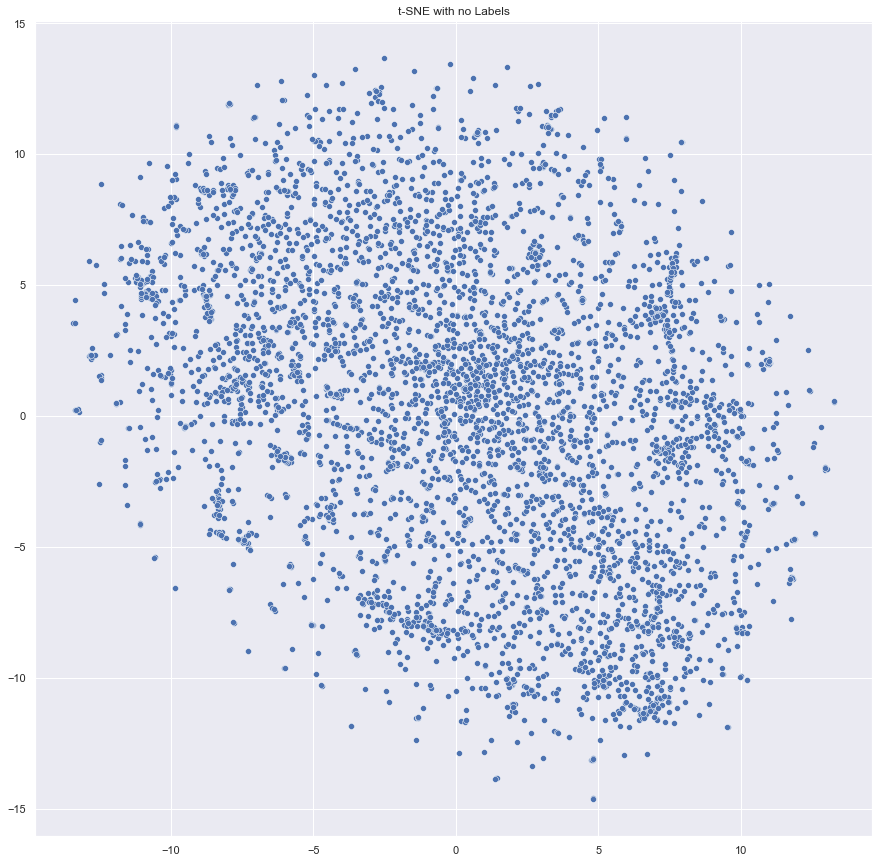

In [110]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


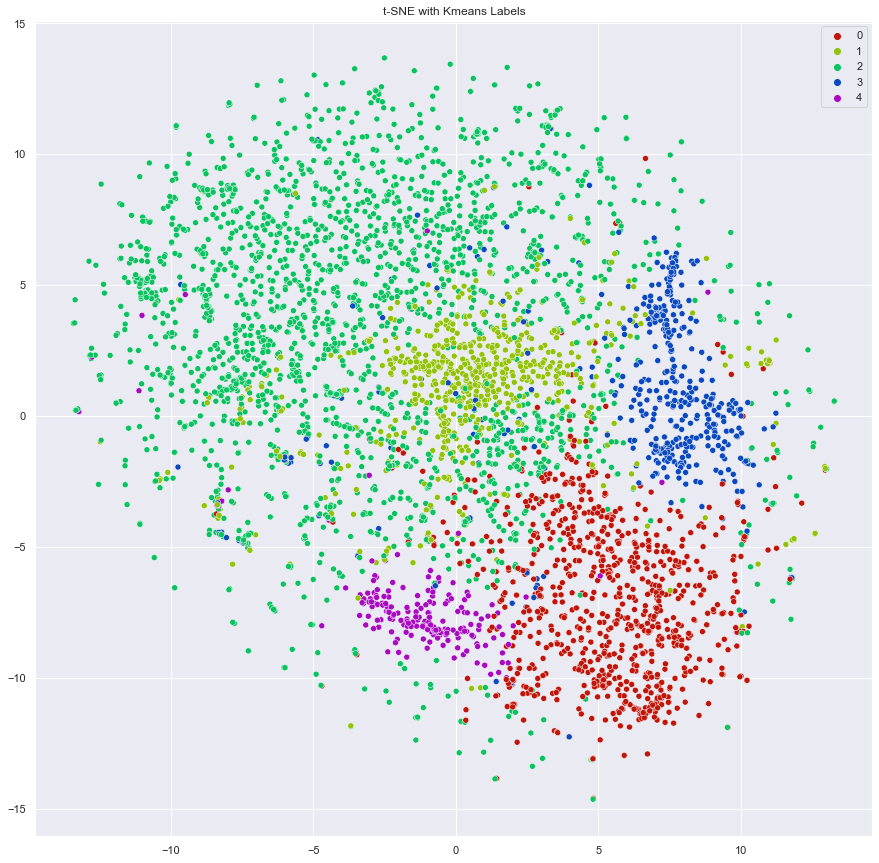

In [111]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(5, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.


# NMF

In [112]:
import en_ner_bc5cdr_md
nlp = spacy.load("en_ner_bc5cdr_md")

In [113]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
nmf = NMF(n_components=20, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X)

In [114]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 4, figsize=(30, 60), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [115]:
#vectorizer = TfidfVectorizer(max_features= 2 ** 12)


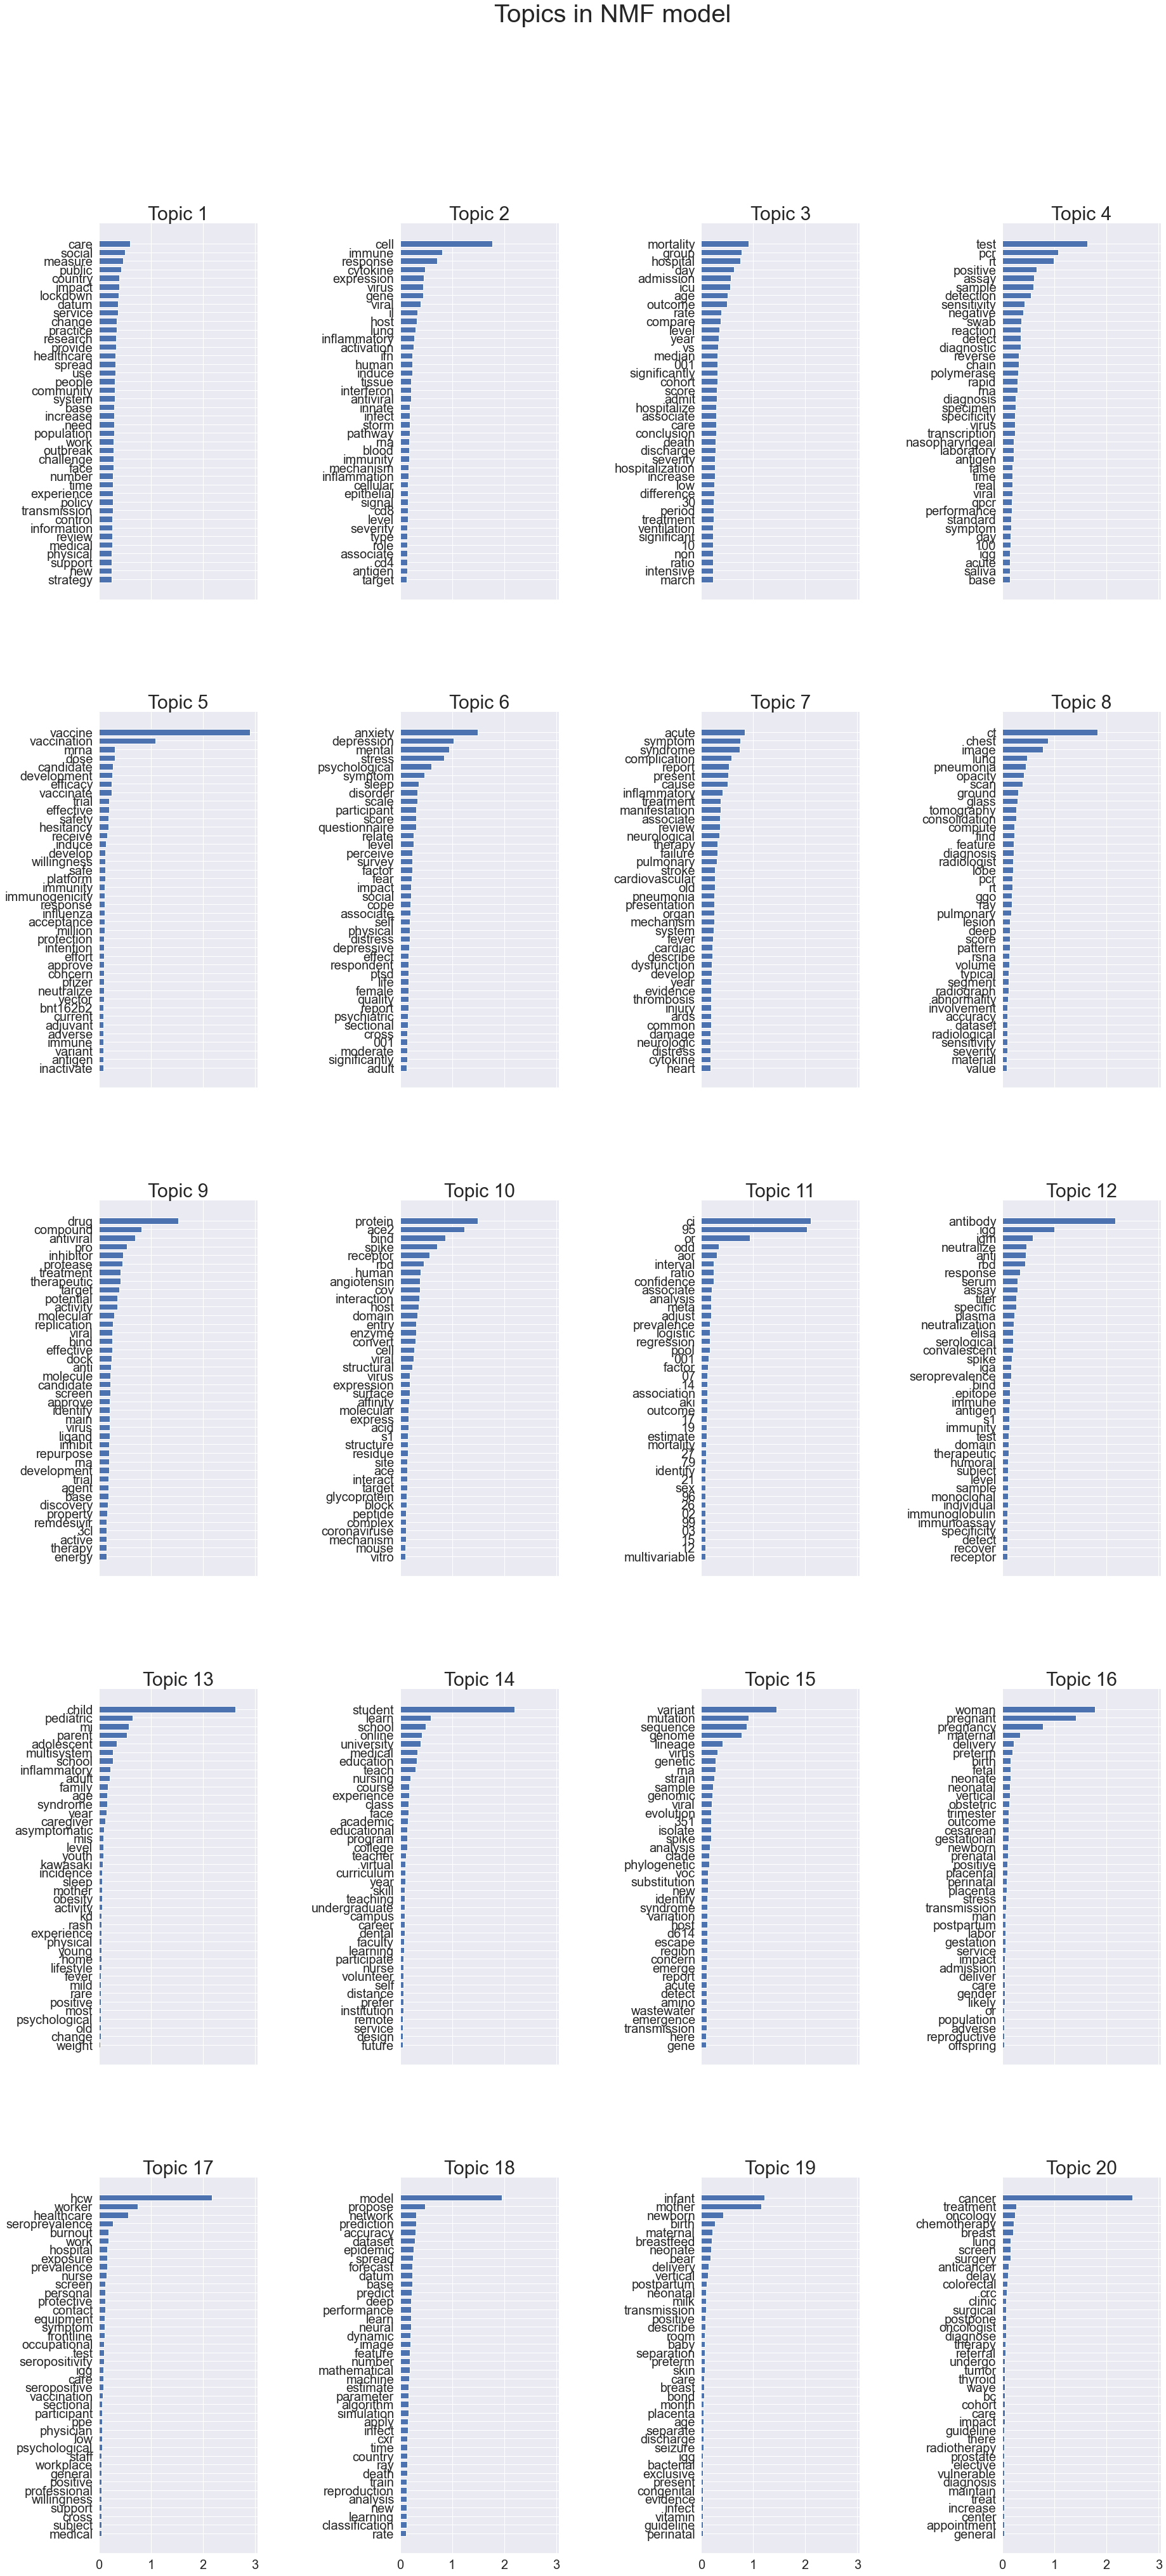

In [116]:
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, 40,
               'Topics in NMF model')

In [117]:
all_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [118]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
care,social,measure,public,country,impact,lockdown,datum,service,change,practice,research,provide,healthcare,spread,use,people,community,system,base,increase,need,population,work,outbreak,challenge,face,number,time,experience,policy,transmission,control,information,review,medical,physical,support,new,strategy
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
cell,immune,response,cytokine,expression,virus,gene,viral,il,host,lung,inflammatory,activation,ifn,human,induce,tissue,interferon,antiviral,innate,infect,storm,pathway,rna,blood,immunity,mechanism,inflammation,cellular,epithelial,signal,cd8,level,severity,type,role,associate,cd4,antigen,target
-------------------------------------------
TERM_LIST :  ['inflammation']

*************Cluster  2 *********************
mortality,group,hospital,day,admission,icu,age,outcome,rate,compare,level,year,vs,median,001,significantly,cohort,score,

cancer,treatment,oncology,chemotherapy,breast,lung,screen,surgery,anticancer,delay,colorectal,crc,clinic,surgical,postpone,oncologist,diagnose,therapy,referral,undergo,tumor,thyroid,wave,bc,cohort,care,impact,guideline,there,radiotherapy,prostate,elective,vulnerable,diagnosis,maintain,treat,increase,center,appointment,general
-------------------------------------------
TERM_LIST :  ['breast,lung,', 'tumor', 'prostate']



# Word's Similarity

In [119]:
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,words)
    print("")
    for token in doc:
        #print(token.text, token.has_vector, token.vector_norm, token.is_oov) 
        if cov_word.similarity(token) > 0.5 :
            print("Similarity Between {",cov_word,"} and {",token,"} is :   ",cov_word.similarity(token))
    print("__________________________________________________________________")


*************Cluster  0 *********************
care social measure public country impact lockdown datum service change practice research provide healthcare spread use people community system base increase need population work outbreak challenge face number time experience policy transmission control information review medical physical support new strategy
-------------------------------------------
TERM_LIST :  []

Similarity Between { coronavirus } and { outbreak } is :    0.5746238784930114
__________________________________________________________________
*************Cluster  1 *********************
cell immune response cytokine expression virus gene viral il host lung inflammatory activation ifn human induce tissue interferon antiviral innate infect storm pathway rna blood immunity mechanism inflammation cellular epithelial signal cd8 level severity type role associate cd4 antigen target
-------------------------------------------
TERM_LIST :  []

Similarity Between { coronavirus }

<ipython-input-119-a9ecc4291df1>:15: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if cov_word.similarity(token) > 0.5 :



*************Cluster  12 *********************
child pediatric mi parent adolescent multisystem school inflammatory adult family age syndrome year caregiver asymptomatic mis level youth kawasaki incidence sleep mother obesity activity kd rash experience physical young home lifestyle fever mild rare positive most psychological old change weight
-------------------------------------------
TERM_LIST :  []

__________________________________________________________________
*************Cluster  13 *********************
student learn school online university medical education teach nursing course experience class face academic educational program college teacher virtual curriculum year skill teaching undergraduate campus career dental faculty learning participate nurse volunteer self distance prefer institution remote service design future
-------------------------------------------
TERM_LIST :  []

__________________________________________________________________
*************Cluster  14

In [120]:
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
top_similar = []
for num_clus in range(0,20):
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    for token in doc:
        if cov_word.similarity(token) > 0.5 :
            top_similar.append((token.text , cov_word.similarity(token)))
LL = top_similar
top_similar_sorted = []
for a in top_similar :
    if a not in top_similar_sorted:
        top_similar_sorted.append(a)
top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
top_similar_sorted

<ipython-input-120-7ae6cfacfccd>:10: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if cov_word.similarity(token) > 0.5 :


[('virus', 0.9999999598655379),
 ('pneumonia', 0.7140130452187041),
 ('viral', 0.6789279758381194),
 ('infect', 0.6573915586705649),
 ('influenza', 0.6127955278394492),
 ('vaccine', 0.5881906817418034),
 ('immunogenicity', 0.5881906817418034),
 ('outbreak', 0.5746238784930114),
 ('bacterial', 0.5350284756573006),
 ('immune', 0.524877441820188),
 ('humoral', 0.524877441820188),
 ('vaccination', 0.516190829505902),
 ('serological', 0.516190829505902),
 ('epidemic', 0.5010447134454742)]

In [121]:
li = top_similar_sorted[0:10]

In [122]:
nlp = spacy.load('en_core_web_md')
lii = []
for tup in li:
    cov_word =nlp(tup[0])
    top_similar = []
    for num_clus in range(0,20):
        str1 = ' '.join(all_keywords[num_clus])
        doc = nlp(str1)
        words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
        for token in doc:
            if cov_word.similarity(token) > 0.5 :
                top_similar.append((token.text , cov_word.similarity(token)))
    top_similar_sorted = []
    for a in top_similar :
        if a not in top_similar_sorted:
            top_similar_sorted.append(a)
    top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
    top_similar_sorted = top_similar_sorted[0:10]
    lii.append((tup[0],top_similar_sorted))
# LL = top_similar
# top_similar_sorted = []
# for a in top_similar :
#     if a not in top_similar_sorted:
#         top_similar_sorted.append(a)
# top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
# top_similar_sorted
top_ten_of_ten = lii
top_ten_of_ten

<ipython-input-122-241254ade84c>:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if cov_word.similarity(token) > 0.5 :


[('virus',
  [('virus', 1.0),
   ('pneumonia', 0.7140130452187041),
   ('viral', 0.6789279758381194),
   ('infect', 0.6573915586705649),
   ('influenza', 0.6127955278394492),
   ('vaccine', 0.5881906817418034),
   ('immunogenicity', 0.5881906817418034),
   ('outbreak', 0.5746238784930114),
   ('bacterial', 0.5350284756573006),
   ('immune', 0.524877441820188)]),
 ('pneumonia',
  [('pneumonia', 1.0),
   ('bacterial', 0.7614367047278192),
   ('virus', 0.7140130557321445),
   ('antiviral', 0.6427989834880435),
   ('complication', 0.634148683064955),
   ('thrombosis', 0.634148683064955),
   ('viral', 0.6289952480578188),
   ('fever', 0.6174868410510352),
   ('acute', 0.6142511956836453),
   ('cardiac', 0.6142511956836453)]),
 ('viral',
  [('viral', 1.0),
   ('virus', 0.6789279468695711),
   ('pneumonia', 0.6289952119582034),
   ('bacterial', 0.5907780408541587),
   ('vaccine', 0.5168299385443638),
   ('immunogenicity', 0.5168299385443638),
   ('influenza', 0.513816028588837),
   ('immune',

In [124]:

ten_diseases = []
for i,mots in top_similar_sorted :
    if mots not in ten_diseases:
        ten_diseases.append(i)
ten_diseases

['humoral',
 'immune',
 'immunity',
 'innate',
 'cytokine',
 'inflammatory',
 'inflammation',
 'epithelial',
 'vitro',
 'pneumonia']

In [125]:
hundred_diseases = []
for i,mots in top_ten_of_ten :
    for mot,val in mots:
        if mot not in hundred_diseases:
            hundred_diseases.append(mot)
hundred_diseases


['virus',
 'pneumonia',
 'viral',
 'infect',
 'influenza',
 'vaccine',
 'immunogenicity',
 'outbreak',
 'bacterial',
 'immune',
 'antiviral',
 'complication',
 'thrombosis',
 'fever',
 'acute',
 'cardiac',
 'humoral',
 'hospitalize',
 'vaccination',
 'serological',
 'epidemic',
 'hospitalization',
 'vaccinate',
 'titer',
 'seropositive',
 'antigen',
 'protease',
 'enzyme',
 'glycoprotein',
 'peptide',
 'antibody',
 'immunity',
 'innate',
 'cytokine',
 'inflammatory',
 'inflammation',
 'epithelial',
 'vitro']

# LDA

In [126]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
tff = tf.fit_transform(text)
lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', random_state=42)
lda.fit(tff)


LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42)

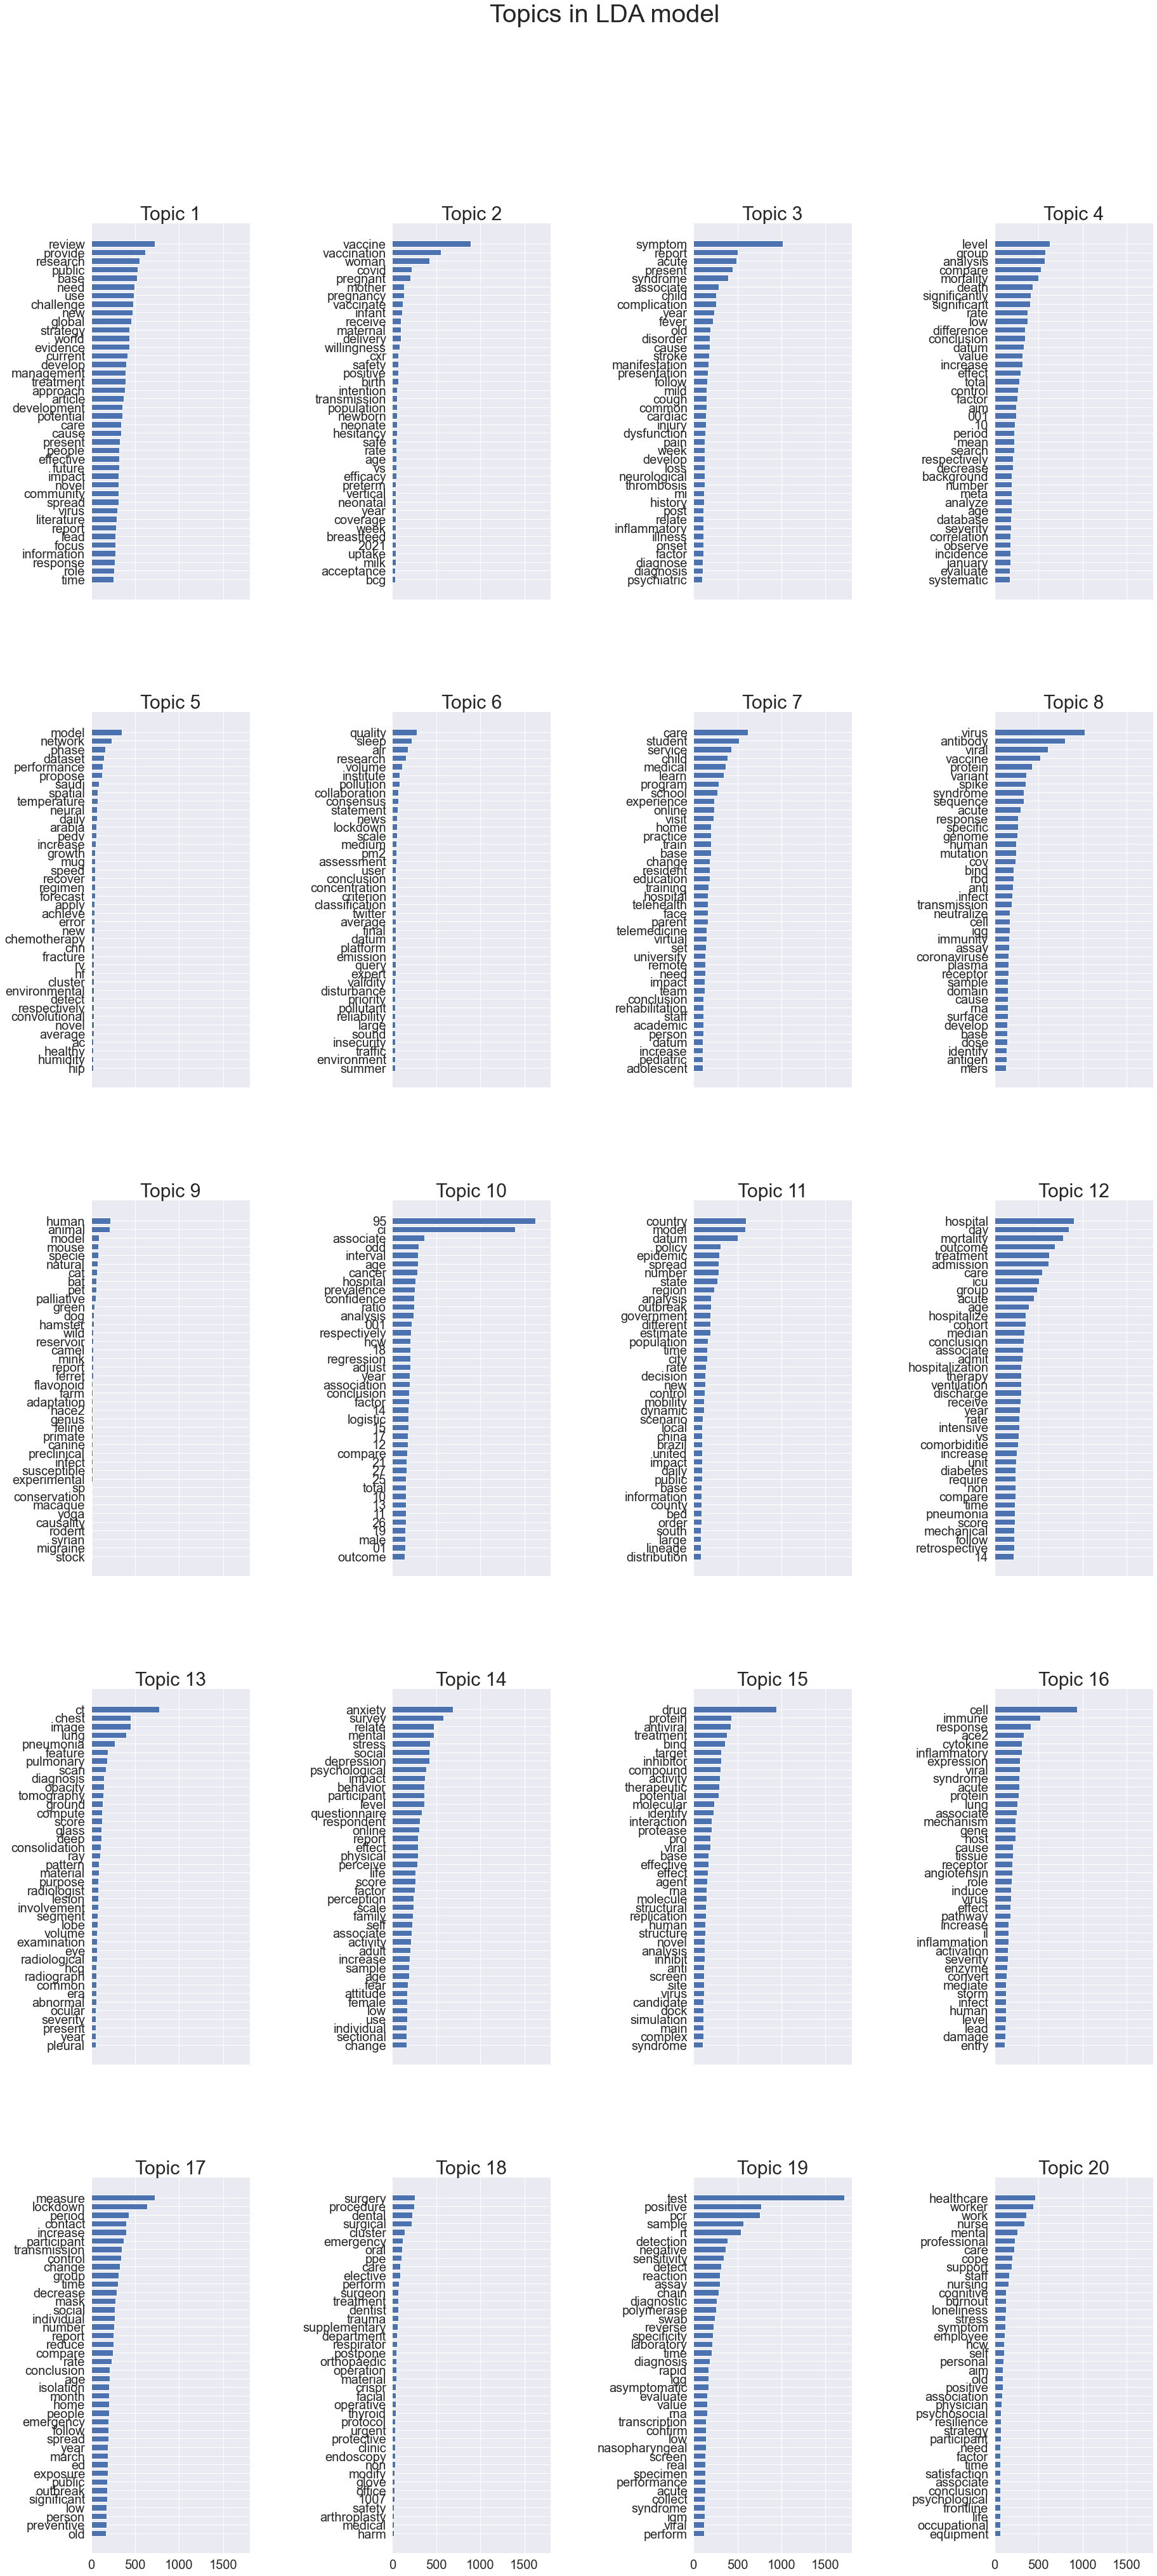

In [127]:
tf_feature_names = tf.get_feature_names()
plot_top_words(lda, tf_feature_names, 40, 'Topics in LDA model')

In [128]:
all_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-100 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [129]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
care,social,measure,public,country,impact,lockdown,datum,service,change,practice,research,provide,healthcare,spread,use,people,community,system,base,increase,need,population,work,outbreak,challenge,face,number,time,experience,policy,transmission,control,information,review,medical,physical,support,new,strategy,reduce,article,report,management,survey,access,period,individual,government,participant,state,contact,intervention,response,emergency,relate,life,world,global,home,approach,analysis,professional,virus,evidence,quality,affect,conduct,find,implement,behavior,activity,staff,visit,crisis,resource,effect,aim,future,knowledge,different,mask,area,current,economic,distancing,epidemic,dental,program,prevention,rate,effective,nurse,online,person,lead,telehealth,technology,level,national
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
cell,immune,response,cytokine,expression,virus,gene,vi

-------------------------------------------
TERM_LIST :  []

*************Cluster  14 *********************
variant,mutation,sequence,genome,lineage,virus,genetic,rna,strain,sample,genomic,viral,evolution,351,isolate,spike,analysis,clade,phylogenetic,voc,substitution,new,identify,syndrome,variation,host,d614,escape,region,concern,emerge,report,acute,detect,amino,wastewater,emergence,transmission,here,gene,protein,spread,nucleotide,cluster,outbreak,e484,primer,circulate,501y,different,human,surveillance,target,deletion,country,bat,reveal,diversity,mink,suggest,acid,global,animal,gisaid,cause,mutational,swab,brazil,reinfection,infectivity,africa,neutralization,specie,find,understand,neutralize,track,nasopharyngeal,provide,these,evolve,rapid,show,belong,complete,harbor,generation,distinct,rapidly,single,immunity,despite,orf1ab,2021,uk,orf10,site,rate,early,wuhan
-------------------------------------------
TERM_LIST :  []

*************Cluster  15 *********************
woman,pregnant,pregn

# LSA

In [130]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [131]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0] ," ",end='')
    print(" ")

Topic 0: 
test  vaccine  virus  care  acute  report  95   
Topic 1: 
vaccine  protein  cell  drug  virus  viral  bind   
Topic 2: 
95  ci  ct  test  pcr  rt  antibody   
Topic 3: 
test  pcr  rt  ct  assay  sample  antibody   
Topic 4: 
vaccine  vaccination  95  ci  antibody  igg  or   
Topic 5: 
vaccine  vaccination  ct  care  treatment  mortality  pneumonia   
Topic 6: 
ci  95  model  drug  compound  or  mortality   
Topic 7: 
ct  vaccine  image  chest  anxiety  model  lung   
Topic 8: 
drug  compound  treatment  antiviral  pro  care  student   
Topic 9: 
care  antibody  protein  group  hospital  ace2  bind   
Topic 10: 
ci  95  cell  care  student  ct  or   
Topic 11: 
antibody  model  igg  response  cytokine  immune  il   
Topic 12: 
child  antibody  pediatric  mi  student  school  lockdown   
Topic 13: 
student  cell  school  learn  rt  online  pcr   
Topic 14: 
student  variant  learn  antibody  symptom  mutation  model   
Topic 15: 
woman  pregnant  pregnancy  child  model  care 

In [132]:
all_keywords = []
for topic_idx, topic in enumerate(svd_model.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)


In [133]:
for num_clus in range(0,19):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
test,vaccine,virus,care,acute,report,95,symptom,treatment,syndrome,group,ci,increase,datum,hospital,mortality,associate,viral,level,find,model,base,analysis,time,antibody,response,cell,positive,age,day,cause,drug,rate,protein,year,measure,factor,effect,control,use
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
vaccine,protein,cell,drug,virus,viral,bind,ace2,human,spike,antibody,antiviral,immune,host,therapeutic,target,receptor,cov,rna,compound,potential,syndrome,variant,response,molecular,development,rbd,cause,protease,replication,acute,gene,interaction,expression,anti,inhibitor,mutation,entry,candidate,mechanism
-------------------------------------------
TERM_LIST :  []

*************Cluster  2 *********************
95,ci,ct,test,pcr,rt,antibody,mortality,day,positive,chest,admission,igg,assay,pneumonia,acute,or,icu,lung,sensitivity,image,hospital,diagnosis,syndrome,laboratory,ig

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [134]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First we will create 20 vectorizers, one for each of our cluster labels

In [135]:
vectorizers = []
    
for ii in range(0, 5):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

Now we will vectorize the data from each of our clusters

In [136]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'text_lemmatized_url_html']))
        #d'ou vient df['y'] =   y_pred = kmeans.fit_predict(X_reduced)      df['y'] = y_pred       df['y']
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [137]:
len(vectorized_data)

5

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

# Topic modeling on each cluster using LDA : 

In [138]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

lda_models = []
for ii in range(0, 5):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [ ]:
for i in range(0,5):
    print(all_keywords[i])

In [ ]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

# Topic modeling on each cluster using NMF : 

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

nmf_models = []
for ii in range(0, 5):
    # nmf
    nmf = NMF(n_components=NUM_TOPICS_PER_CLUSTER, random_state=1,alpha=.1, l1_ratio=.5)
    nmf_models.append(nmf)
    
nmf_models[0]

In [ ]:
clusters_nmf_data = []

for current_cluster, nmf in enumerate(nmf_models):
    print("Current Cluster: " + str(current_cluster))
    if vectorized_data[current_cluster] != None:
        clusters_nmf_data.append((nmf.fit_transform(vectorized_data[current_cluster])))

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
all_keywords = []
for current_vectorizer, nmf in enumerate(nmf_models):
    # print("Current Cluster: " + str(current_vectorizer))
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(nmf, vectorizers[current_vectorizer]))

In [ ]:
for i in range(0,5):
    print(all_keywords[i])

## travail realisé :
 - detection automatique des noms de maladies
 - construction d'un corpus en utilisant les noms des maladies detectés

In [ ]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")


In [ ]:
from Bio import Entrez
from Bio import Medline
import json


MAX_COUNT = 3
for TERM in ten_diseases:
    Entrez.email = 'A.N.Other@example.com'
    h = Entrez.esearch(db='pubmed', retmax=MAX_COUNT, term=TERM)
    result = Entrez.read(h)
    ids = result['IdList']
    h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
    records = Medline.parse(h)
    i=0
    for record in records:
        filename="fichier_"+TERM+str(i)+".json"
        json.dump(record, open(".\\new_corpus\\"+filename, 'w'))
        data = json.load(open(".\\new_corpus\\"+filename))
        i=i+1
[(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]

In [ ]:
len(all_keywords)